<a href="https://colab.research.google.com/github/ravi4biz/ML-Notebooks/blob/master/Predicting_housing_prices_in_King_County_4_29%2C_USA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 
### We are exploring the housing sale prices in King County, USA between the time period May 2014 - May 2015. 
#### Firstly, I will go through a thorough data exploration to identify most important features and to explore the intercorrelation between features. After that I apply data normalization between varialbes and conduct feature engineering, Finally, I will be applying different machine learning algorithms and evaluating their respective success to a cross-validated splitted train-test set.

In [0]:
#Importing fundamental data exploration libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

df = pd.read_csv("https://raw.githubusercontent.com/ravi4biz/datasets/master/kc_house_data.csv")
df.rename(columns ={'price': 'SalePrice'}, inplace =True)

df.head()

,id,date,SalePrice,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [0]:
#checking the columns in the dataset
df.columns

#### At a first glance, the column  date can be removed as it serves unsignificant value (timeframe is one year).  The features seem to be pre-selected as  important influencers for a sale price of a house. 

Given from the histogram: The saleprice has appreciable positive skewness,
deviates from the normal distribution and
shows peakedness.
Let's take a look at the skewness and kurtosis in numbers:

In [0]:
df.corr(method='spearman').style.background_gradient()

,id,SalePrice,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.004178,0.006250,0.015051,0.001656,-0.116792,0.018837,-0.003573,0.012552,-0.023969,0.019835,0.003523,0.001408,0.026537,-0.017473,-0.005359,-0.003732,0.007413,-0.000035,-0.114735
SalePrice,0.004178,1.000000,0.344652,0.497160,0.644191,0.074939,0.322347,0.115089,0.293931,0.018490,0.658215,0.541752,0.251704,0.102038,0.101876,-0.008735,0.456409,0.063537,0.572290,0.062766
bedrooms,0.006250,0.344652,1.000000,0.521406,0.647366,0.216531,0.227541,-0.007598,0.081421,0.012660,0.380534,0.539704,0.230496,0.180022,0.016877,-0.167186,-0.021185,0.191389,0.443816,0.201577
bathrooms,0.015051,0.497160,0.521406,1.000000,0.745526,0.068805,0.546800,0.049522,0.155549,-0.162891,0.658194,0.691006,0.191848,0.566982,0.042688,-0.204783,0.008283,0.261539,0.570304,0.063111
sqft_living,0.001656,0.644191,0.647366,0.745526,1.000000,0.304159,0.401267,0.070326,0.232994,-0.062638,0.716400,0.843504,0.327878,0.352421,0.052679,-0.206848,0.030980,0.284584,0.746982,0.283864
sqft_lot,-0.116792,0.074939,0.216531,0.068805,0.304159,1.000000,-0.234433,0.085601,0.117033,0.114724,0.152049,0.272408,0.036624,-0.037569,0.008536,-0.319494,-0.122052,0.370551,0.359572,0.922316
floors,0.018837,0.322347,0.227541,0.546800,0.401267,-0.234433,1.000000,0.023879,0.019655,-0.287915,0.501684,0.599280,-0.272458,0.551663,0.012579,-0.061461,0.024564,0.148651,0.305434,-0.231386
waterfront,-0.003573,0.115089,-0.007598,0.049522,0.070326,0.085601,0.023879,1.000000,0.284924,0.016744,0.062189,0.054490,0.051969,-0.028605,0.091649,0.029591,-0.019044,-0.038139,0.074564,0.092271
view,0.012552,0.293931,0.081421,0.155549,0.232994,0.117033,0.019655,0.284924,1.000000,0.046000,0.217044,0.144394,0.236525,-0.066607,0.096539,0.078215,-0.000073,-0.102728,0.255793,0.116520
condition,-0.023969,0.018490,0.012660,-0.162891,-0.062638,0.114724,-0.287915,0.016744,0.046000,1.000000,-0.167374,-0.158126,0.161623,-0.393816,-0.066180,-0.022416,-0.022341,-0.085270,-0.086905,0.117719


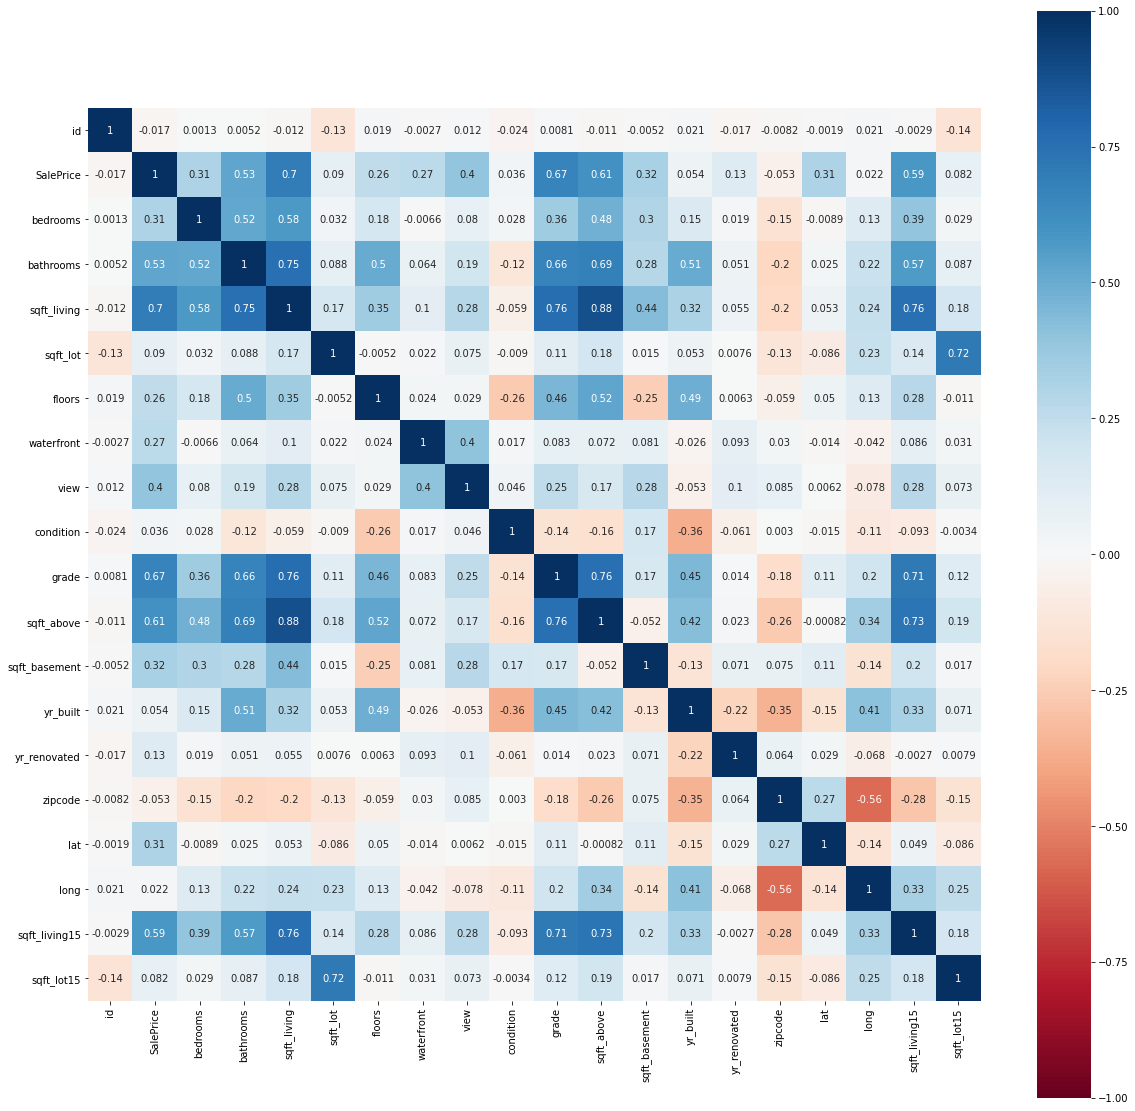

In [0]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True, ax=ax)

This is quite significant. At the data standardisation section, we will fix this. 

# 2. Feature exploration 

##### In this section I will be investigating different features by plotting them to determine the relationship to SalePrice. 

In [0]:
var = 'sqft_living15'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(3,8000000));

There's clearly a linear relationship with a significant portion of outliers. 

In [0]:
var = 'bedrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

In [0]:
var = 'grade'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

In [0]:
var = 'bathrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

#### Clearly, as the features  "bathrooms", "grade", "bedrooms" increase, so does the SalePrice. This is most evident in case of the features bathrooms and grade. 

In [0]:
var = 'yr_built'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

#### Interestingly enough, one would expect a linear relationship with newer houses being significantly more expensive. However, this is not the case, as seen by the graph. Next let's explore intercolleration between features.

In [0]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

#### There are some interesting correlation between variables - let's take a closer look:

In [0]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Okay, so the features: square foot living area, grade(amount of floors), square feet abouve the ground level and sqft_15 features displayed the highest correlation wih the price of the house. 
#### Moreover, there is a high correlation of sqft_living with e.g. number of bathrooms and grade. This is common sense, as the square feet increase, so does the number of floors and bathrooms. There is potential to implement clever feature engineering here. 

In [0]:
#scatterplot
sns.set()
cols = ['SalePrice', 'sqft_living', 'grade', 'sqft_above', 'view', 'bathrooms']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();


#### These overall scatterplots confirm the findings of the heatmap.  There is myriad of linear correlation between sqft_living, sqft_above, bathrooms and grade. This yields an opportunity for to combine features. Moreover, what we learned that the above mentioned features have the biggest impact on sale price. One would also expect location to play a role, but as they are in latitude/longitude coordinates, it requires advanced data manipulation to take it into account. Finally, due to many linear relationships we can apply regression models. 

Let's check for missing data before we proceed any further:

In [0]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

#### This dataset is clean of missing data. What a miracle. 

# Standardization of data

In [0]:
#standardizing data to mitigate skewdness and kurtosis
from sklearn.preprocessing import StandardScaler
saleprice_scaled = StandardScaler().fit_transform(df['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.26686039]
 [-1.25868864]
 [-1.25324081]
 [-1.2505169 ]
 [-1.24779298]
 [-1.24643103]
 [-1.24506907]
 [-1.24234515]
 [-1.23962124]
 [-1.23962124]]

outer range (high) of the distribution:
[[10.75649871]
 [10.78646177]
 [11.24407943]
 [12.45022882]
 [12.96559346]
 [13.10178919]
 [13.70105041]
 [17.28299812]
 [17.76649297]
 [19.50298853]]




### Let's normalise the Saleprice and sqft_living feature

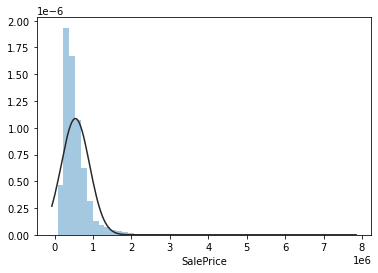

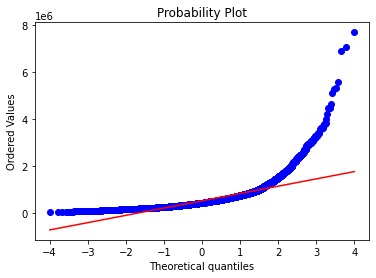

In [0]:
from scipy.stats import norm
from scipy import stats
#histogram and normal probability plot
sns.distplot(df['SalePrice'], fit=norm, bins=50, kde=False);
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)

#### We'll fix it by taking the log and fitting the plot to a normal distribution curve

In [0]:
#applying log transformation
df['SalePrice'] = np.log(df['SalePrice'])

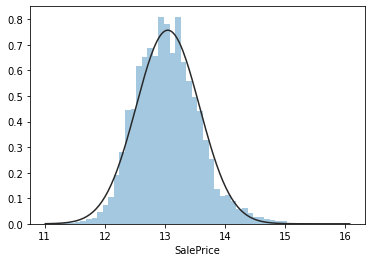

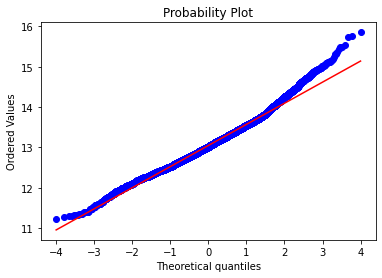

In [0]:
#transformed histogram and normal probability plot
sns.distplot(df['SalePrice'], fit=norm,  bins=50, kde=False);
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)

Done! Now for sqft_living

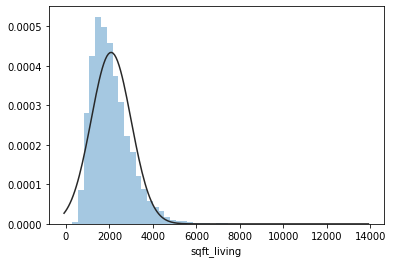

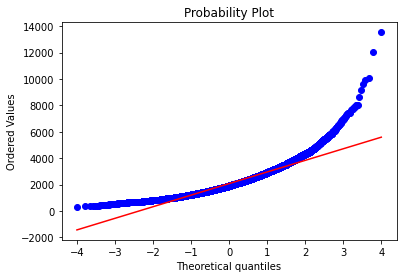

In [0]:
#histogram and normal probability plot
sns.distplot(df['sqft_living'], fit=norm, bins=50, kde=False);
fig = plt.figure()
res = stats.probplot(df['sqft_living'], plot=plt)

In [0]:
#data transformation
df['sqft_living'] = np.log(df['sqft_living'])

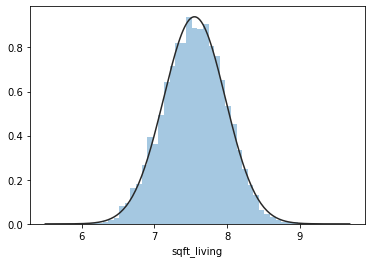

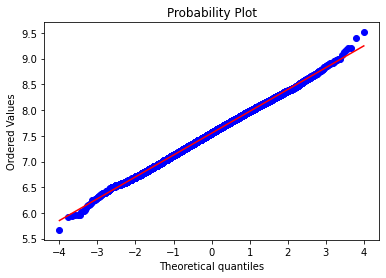

In [0]:
#transformed histogram and normal probability plot
sns.distplot(df['sqft_living'], fit=norm, bins=50, kde=False);
fig = plt.figure()
res = stats.probplot(df['sqft_living'], plot=plt)

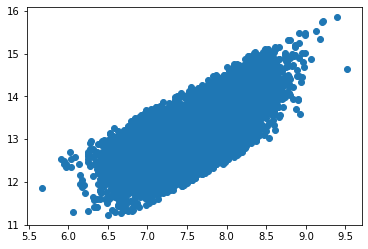

In [0]:
#scatter plot
plt.scatter(df['sqft_living'], df['SalePrice']);


#### Now there is a nice linear relationship between the features 

## 4. Fitting Machine Learning Models

In [0]:
df.head()

,id,date,SalePrice,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,12.309982,3,1.00,7.073270,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,13.195614,3,2.25,7.851661,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,12.100712,2,1.00,6.646391,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,13.311329,4,3.00,7.580700,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,13.142166,3,2.00,7.426549,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [0]:
Y = df.SalePrice.values


In [0]:
feature_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors',
       'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']
X=df[feature_cols]

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X, Y, random_state=3)

In [0]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
accuracy = regressor.score(x_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 77%'

#### So 77% accuracy with simple linear regression. Let's try more advanced algorithms. 
## Elastic Net

In [0]:
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle


In [0]:
# For accurate scoring
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

In [0]:
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [0]:
from sklearn import ensemble, tree, linear_model
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train, y_train)

In [37]:
train_test(ENSTest, x_train, x_test, y_train, y_test)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
             cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: 0.6968192751346299
RMSE: 0.25334711751590516
Test
R2: 0.6936720526212137
RMSE: 0.2524594450452316


In [38]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(ENSTest, x_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.77 (+/- 0.03)


#### Interesting that the accuracy is the same. RSME, which is a better measure of performance, is 0.25

## Gradient Boosting

#### As previously seen, we have many outliers. So I'm using max_features='sqrt' to reduce overfitting of my model. I also use loss='huber' because it more tolerant to outliers. All other hyper-parameters was chosen using GridSearchCV.

In [0]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train, x_test, y_train, y_test)

In [0]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(GBest, x_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Gradient boosting seems to work well for this data set

In [0]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt

## Linear Regression and Lasso

In [0]:
# Defining two functions for error measuring: RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

X_train= x_train
X_test= x_test

In [0]:
# Linear Regression
lr = LinearRegression()
lr.fit(x_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 11.5, xmax = 15.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11.5, 15.5], [11.5, 15.5], c = "red")
plt.show()

#### Fundamentally same result as ElasticNet and simple linear regression

In [0]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 11.5, xmax = 15.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11.5, 15.5], [11.5, 15.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [0]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 11.5, xmax = 15.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11.5, 15.5], [11.5, 15.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [0]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 11.5, xmax = 15.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11.5, 15.5], [11.5, 15.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

### The previous linear regressions with different regulations yielded almost identical results. Conclusively, Gradient boosting seemed to work best for this dataset at accurately predicting the sale prices. With R2: 0.89, RMSE 0.164 and accuracy of 0.87


#### Any feedback or comments are wholeheartedly welcome, as this is my first kernel 